# RECRUITERS

## Simple analysis of users contacted by recruiters

This notebook tries to get insights into which kind of users or pairs (users, jobs) recruiters prefer or interact with.

We will look at characteristics of the users contacted by recruiters and then we will compare them with the characteristics of the rest of the users. Similarly we will do the same analysis for jobs that use recruiters to fill the positions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Import all the interactions of type recruiter which we have previously saved in a csv file
folderData = 'data/'
recruiter_interactions = pd.read_csv(folderData + 'interactions_recruiter.csv')
recruiter_interactions.head()

,user_id,item_id,interaction_type
0,252360,4020,5
1,709236,9860,5
2,709236,9860,5
3,709236,9860,5
4,709236,9860,5


In [3]:
# Import all users
users = pd.read_csv(folderData + 'users.csv', sep='\t')
users.columns = ['user_id', 'jobroles', 'career_level', 'discipline_id', 'industry_id', 'country', 'region',
                'experience_n_entries_class', 'experience_years_experience', 'experience_years_in_current',
                'edu_degree', 'edu_fieldofstudies', 'wtcj', 'premium']

In [4]:
# Fill empties and transform the strings into a list
users.jobroles = users.jobroles.fillna('0').apply(lambda str: set(str.split(',')))
users.edu_fieldofstudies = users.edu_fieldofstudies.fillna('0').apply(lambda str: set(str.split(',')))

In [5]:
# Import all items
items = pd.read_csv(folderData + 'items.csv', sep='\t')
items.columns = ['item_id', 'title', 'career_level', 'discipline_id', 'industry_id', 'country', 'is_payed', 'region',
                'latitude', 'longitude', 'employment', 'tags', 'created_at']

In [6]:
# Fill empties and transform the strings into a list
items.title = items.title.fillna('0').apply(lambda str: set(str.split(',')))
items.tags = items.tags.fillna('0').apply(lambda str: set(str.split(',')))
items['created_at_dt'] = pd.to_datetime(items.created_at,unit='s', errors='coerce')

In [7]:
# Merge data sets. Find all the information of users and items that have been contacted by recruiters
data = recruiter_interactions.merge(users, on='user_id', how='inner')
data = data.merge(items, on='item_id', how='inner', suffixes=('_user', '_item'))
data.head()

,user_id,item_id,interaction_type,jobroles,career_level_user,discipline_id_user,industry_id_user,country_user,region_user,experience_n_entries_class,...,industry_id_item,country_item,is_payed,region_item,latitude,longitude,employment,tags,created_at,created_at_dt
0,252360,4020,5,{1774824},3,17,4,de,3,3,...,16,de,0,2,49.5,11.1,1,"{2791363, 595799, 898848, 1881148, 4100957, 17...",1450998000,2015-12-24 23:00:00
1,252360,1924354,5,{1774824},3,17,4,de,3,3,...,16,de,0,7,50.1,8.7,1,"{2791363, 595799, 1774824, 4481635, 800184, 28...",1479510000,2016-11-18 23:00:00
2,709236,9860,5,{1469577},3,0,0,de,0,3,...,16,de,0,5,53.1,8.8,1,"{3989138, 908629, 3671787, 4538695, 3627481, 4...",1482447600,2016-12-22 23:00:00
3,709236,9860,5,{1469577},3,0,0,de,0,3,...,16,de,0,5,53.1,8.8,1,"{3989138, 908629, 3671787, 4538695, 3627481, 4...",1482447600,2016-12-22 23:00:00
4,709236,9860,5,{1469577},3,0,0,de,0,3,...,16,de,0,5,53.1,8.8,1,"{3989138, 908629, 3671787, 4538695, 3627481, 4...",1482447600,2016-12-22 23:00:00


In [8]:
# Remove column interaction_type as it is always 3
data.drop(['interaction_type'], axis=1, inplace=True)
data.shape

(100971, 28)

In [9]:
print data.columns

Index([u'user_id', u'item_id', u'jobroles', u'career_level_user',
       u'discipline_id_user', u'industry_id_user', u'country_user',
       u'region_user', u'experience_n_entries_class',
       u'experience_years_experience', u'experience_years_in_current',
       u'edu_degree', u'edu_fieldofstudies', u'wtcj', u'premium', u'title',
       u'career_level_item', u'discipline_id_item', u'industry_id_item',
       u'country_item', u'is_payed', u'region_item', u'latitude', u'longitude',
       u'employment', u'tags', u'created_at', u'created_at_dt'],
      dtype='object')


In [10]:
# Select all users and items who have not been involved with recruiters
idx = users.user_id.isin(data.user_id)
users_not_recruited = users.ix[~idx].reset_index(drop=True)
idx = items.item_id.isin(data.item_id)
items_not_recruited = items.ix[~idx].reset_index(drop=True)

# Let's study each one of the columns separately

## Career level

Which career level do users have? Does it match the career level asked at the job?

In [11]:
data.career_level_user.value_counts().sort_index().to_dict()

{0: 7161, 1: 700, 2: 3493, 3: 52602, 4: 21116, 5: 11797, 6: 4102}

In [12]:
data.career_level_item.value_counts().sort_index().to_dict()

{1: 1043, 2: 1552, 3: 60931, 4: 26661, 5: 10516, 6: 268}

Lets only look at the data for which we know the career level (ignore case 0)

In [13]:
subset = data[data.career_level_user!=0]
n = float(len(subset))
print np.sum(subset.career_level_item==subset.career_level_user)/n*100.0
print np.sum(subset.career_level_item>subset.career_level_user)/n*100.0
print np.sum(subset.career_level_item<subset.career_level_user)/n*100.0

65.4269267669
15.5271293039
19.0459439292


It looks important that a recruiter matches the career level of the user with the one of the job (65.5% of the times), or maybe gets a user over qualified (19.5%), but less times underqualified (15%)

In [14]:
diff_career_level = subset.career_level_user-subset.career_level_item
diff_career_level.value_counts().sort_index().to_dict()

{-3: 92, -2: 1048, -1: 13426, 0: 61377, 1: 11986, 2: 5172, 3: 709}

If the level does not match, one up one down could be admissible

How does the career level of the users contacted differ from the general users group? And what about the jobs? Do recruiters work only for a particular type of job career-level?

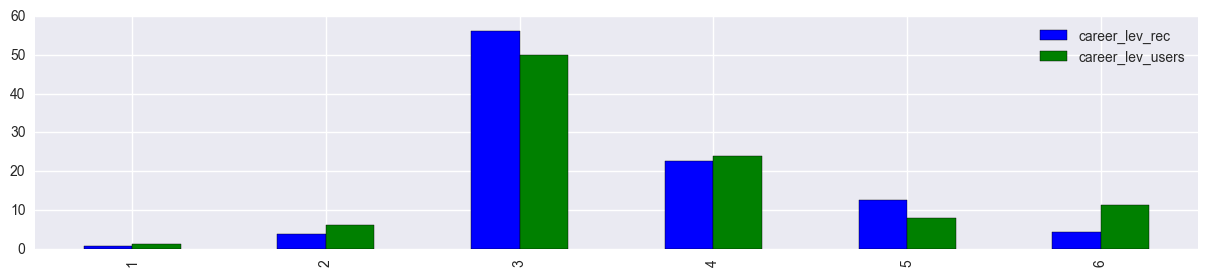

In [15]:
career_lev_users = users_not_recruited[users_not_recruited.career_level!=0].career_level.value_counts()/float(len(users_not_recruited[users_not_recruited.career_level!=0]))*100
career_lev_rec = subset.career_level_user.value_counts()/float(len(subset))*100
df = pd.DataFrame({'career_lev_users':career_lev_users, 'career_lev_rec':career_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['blue', 'green']);

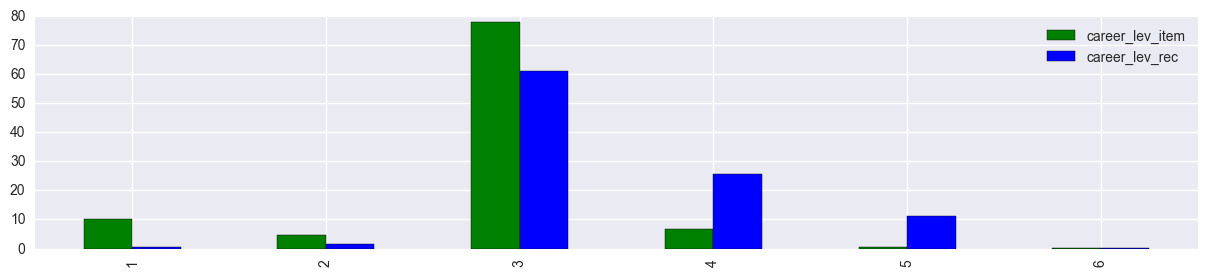

In [16]:
career_lev_item = items_not_recruited[items_not_recruited.career_level!=0].career_level.value_counts()/float(len(items_not_recruited[items_not_recruited.career_level!=0]))*100
career_lev_rec = subset.career_level_item.value_counts()/float(len(subset))*100
df = pd.DataFrame({'career_lev_item':career_lev_item, 'career_lev_rec':career_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusion:

1. Recruiters prefer (user,item) pairs with the same career level, and maximum one up or one down
2. Recruiters are used more (in proportion) for jobs with career level >= manager

## Discipline id

Let's ask the same questions

In [17]:
data.discipline_id_user.value_counts()

0     43040
21    18434
17    11536
2      6820
4      6567
5      6155
16     2948
7      2198
3      1113
18      377
11      374
1       283
23      273
13      239
6       213
8       106
9        94
22       61
14       58
20       40
10       37
19        5
Name: discipline_id_user, dtype: int64

In [18]:
data.discipline_id_item.value_counts()

21    22087
17    15495
5     12781
7     11705
16    10873
1      8614
2      5024
4      3299
3      2501
23     2057
12     1584
13     1203
11      822
6       749
20      447
19      441
10      413
22      323
15      194
18      157
8       105
14       97
Name: discipline_id_item, dtype: int64

In [19]:
# Remove the unknowns which are labelled as 0 and compute percentages
subset = data[data.discipline_id_user!=0]
n = float(len(subset))
print np.sum(subset.discipline_id_item==subset.discipline_id_user)/n*100.0

69.0545649134


Having a discpline match, seems important for a recruiter, however there are many users that do not specify the discipline

Are recruiters used more for jobs of a specific discipline?

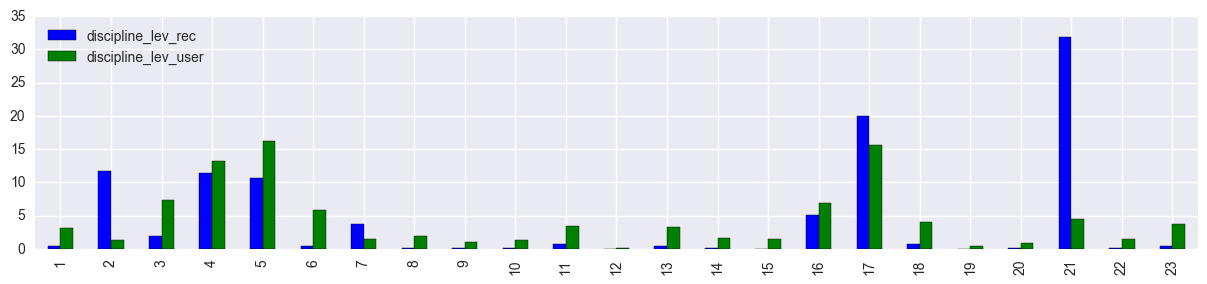

In [20]:
discipline_lev_user = users_not_recruited[users_not_recruited.discipline_id!=0].discipline_id.value_counts()/len(users_not_recruited[users_not_recruited.discipline_id!=0])*100
discipline_lev_rec = subset.discipline_id_user.value_counts()/float(len(subset))*100
df = pd.DataFrame({'discipline_lev_user':discipline_lev_user, 'discipline_lev_rec':discipline_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['blue', 'green']);

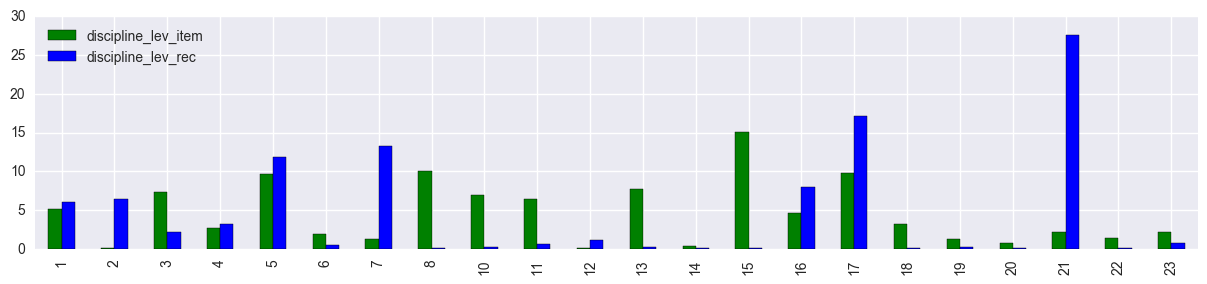

In [21]:
discipline_lev_item = items_not_recruited[items_not_recruited.discipline_id!=0].discipline_id.value_counts()/len(items_not_recruited[items_not_recruited.discipline_id!=0])*100
discipline_lev_rec = subset.discipline_id_item.value_counts()/float(len(subset))*100
df = pd.DataFrame({'discipline_lev_item':discipline_lev_item, 'discipline_lev_rec':discipline_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions

    1. Many users do not specify discipline, but recruiters seem to like a match (70%)
    2. There are disciplines like 21 or 17 or 7 or 2 where recruiters are normally used

## industry_id

In [22]:
data.industry_id_user.value_counts().head(n=10)

16    32183
0     31356
18     9731
9      7936
15     6226
20     2959
7      2692
8      2030
3      1294
6      1216
Name: industry_id_user, dtype: int64

In [23]:
data.industry_id_item.value_counts().head(n=10)

16    48541
9     15904
3     14190
15     5904
21     3825
13     2450
14     2186
8      1581
7      1383
5      1104
Name: industry_id_item, dtype: int64

In [24]:
subset = data[data.industry_id_user!=0]
n = float(len(subset))
print np.sum(subset.industry_id_item==subset.industry_id_user)/n*100.0

50.4273504274


Having a match is not as relevant as before

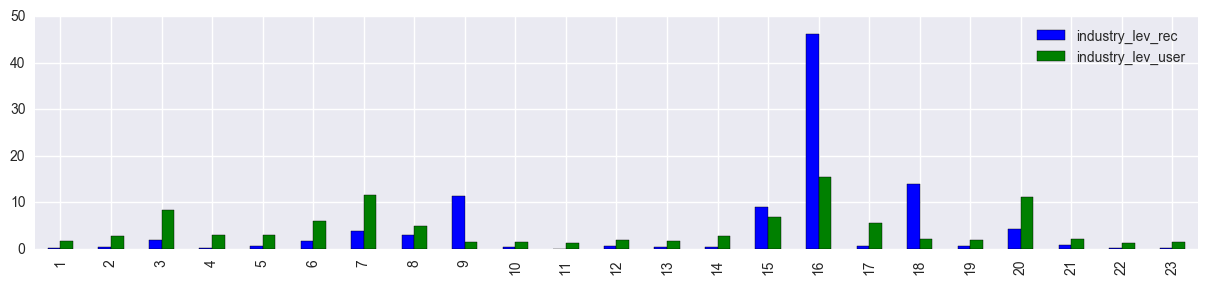

In [25]:
industry_lev_user = users_not_recruited[users_not_recruited.industry_id!=0].industry_id.value_counts()/len(users_not_recruited[users_not_recruited.industry_id!=0])*100
industry_lev_rec = subset.industry_id_user.value_counts()/float(len(subset))*100
df = pd.DataFrame({'industry_lev_user':industry_lev_user, 'industry_lev_rec':industry_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['blue', 'green']);

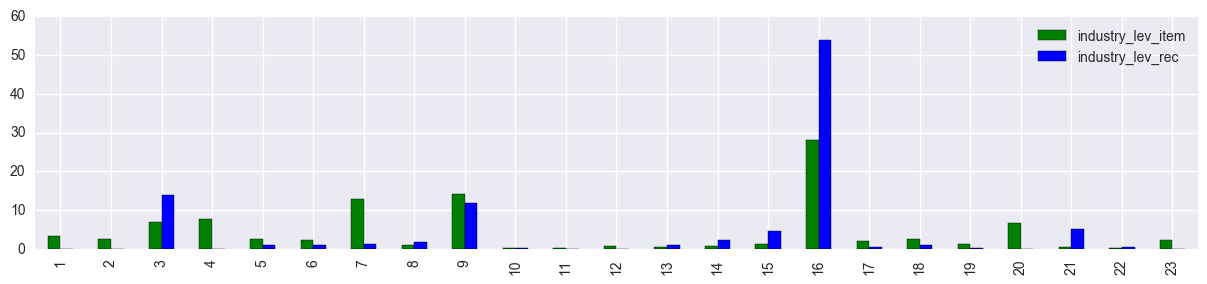

In [26]:
industry_lev_item = items_not_recruited[items_not_recruited.industry_id!=0].industry_id.value_counts()/len(items_not_recruited[items_not_recruited.industry_id!=0])*100
industry_lev_rec = subset.industry_id_item.value_counts()/float(len(subset))*100
df = pd.DataFrame({'industry_lev_item':industry_lev_item, 'industry_lev_rec':industry_lev_rec})
df.plot(kind='bar', figsize=(15, 3), color=['green', 'blue']);

Conclusions: 

    1. Recruiters are used more for industry 16 (jobs and users) and for users from industry 9 and 18

## experience_n_entries_class

In [27]:
data.experience_n_entries_class.value_counts()/float(len(data))*100

3    74.526349
2    18.545919
1     6.927732
Name: experience_n_entries_class, dtype: float64

In [28]:
users_not_recruited.experience_n_entries_class.value_counts()/float(len(users_not_recruited))*100

3    47.258132
1    29.583308
2    23.158560
Name: experience_n_entries_class, dtype: float64

Conclusions: 

    1. Important to have value 3 for recruiters and not value 1

## experience_years_experience & experience_years_in_current

In [29]:
data.experience_years_experience.value_counts()/float(len(data))*100

4    25.455824
5    23.052163
7    21.275416
6    13.812877
3    10.183122
0     4.218043
2     1.576690
1     0.425865
Name: experience_years_experience, dtype: float64

In [30]:
users_not_recruited.experience_years_experience.value_counts()/float(len(users_not_recruited))*100

7    20.992196
5    19.980986
4    18.294186
6    17.652895
0    16.688351
3     3.834778
2     2.038667
1     0.517940
Name: experience_years_experience, dtype: float64

Conclusion:
1. Recruiters do not contact users with 0, 1, 2 or 3 

In [31]:
data.experience_years_in_current.value_counts()/float(len(data))*100

2    41.901140
1    33.389785
4     8.037951
3     7.149578
0     5.402541
5     3.655505
6     0.414971
7     0.048529
Name: experience_years_in_current, dtype: float64

In [32]:
users_not_recruited.experience_years_in_current.value_counts()/float(len(users_not_recruited))*100

2    25.089455
0    18.490345
4    16.831625
3    14.078124
1    13.345439
5     6.011638
6     3.553645
7     2.599730
Name: experience_years_in_current, dtype: float64

Conclusion:
    1. Recruiters seem to target more users with 1 or 2 years at the current job, and nearly never users with more than 5 years at current job

## edu_degree

In [33]:
data.edu_degree.value_counts()/float(len(data))*100

2    42.319082
0    39.288509
1    16.956354
3     1.436056
Name: edu_degree, dtype: float64

In [34]:
users_not_recruited.edu_degree.value_counts()/float(len(users_not_recruited))*100

0    64.624478
2    21.829245
1     9.175641
3     4.370636
Name: edu_degree, dtype: float64

Conclusion:
    1. Recruiters contact more users with masters degree 

## field of studies

In [35]:
# Count how many times each field of study appears
field_of_studies = data.edu_fieldofstudies.apply(lambda x: list(x))
field_of_studies_users_not_rec = users_not_recruited.edu_fieldofstudies.apply(lambda x: list(x))

In [36]:
import itertools
field_of_studies = list(itertools.chain.from_iterable(field_of_studies.values.flatten()))
field_of_studies_users_not_rec = list(itertools.chain.from_iterable(field_of_studies_users_not_rec.values.flatten()))

In [37]:
from collections import Counter
{k: v/float(len(field_of_studies))*100 for k, v in dict(Counter(field_of_studies)).items()}

{'0': 24.94023168874325,
 '1': 0.3553791480131075,
 '2': 6.441131674897309,
 '3': 6.951585360225228,
 '4': 3.835325610375225,
 '5': 9.994000092306273,
 '6': 0.07661420593529329,
 '7': 9.476161905201458,
 '8': 37.444962385194074,
 '9': 0.484607929108783}

In [38]:
{k: v/float(len(field_of_studies_users_not_rec))*100 for k, v in dict(Counter(field_of_studies_users_not_rec)).items()}

{'0': 49.011563541372404,
 '1': 0.36099364737720185,
 '2': 4.194573103377083,
 '3': 12.566535023492403,
 '4': 1.7574332857159636,
 '5': 9.450430441654712,
 '6': 0.8250312006067659,
 '7': 4.295453519904411,
 '8': 16.703868380727144,
 '9': 0.8341178557719113}

Conclusions: 
    1. Recruiters like the field of study 8
    2. field of study 0 is less popular amongst recruiters

## WTCJ

In [39]:
data.wtcj.value_counts()/len(data)*100

1    69.441721
0    30.558279
Name: wtcj, dtype: float64

In [40]:
users_not_recruited.wtcj.value_counts()/len(users_not_recruited)*100

1    76.837428
0    23.162572
Name: wtcj, dtype: float64

Conclusion:
    1. There is not a lot of difference between both groups

## premium

In [41]:
data.premium.value_counts()/len(data)*100

0    60.376742
1    39.623258
Name: premium, dtype: float64

In [42]:
users_not_recruited.premium.value_counts()/len(users_not_recruited)*100

0    80.797028
1    19.202972
Name: premium, dtype: float64

Conclusion:
1. The proportion of premium users contacted by recruiters is double

## employment

In [43]:
data.employment.value_counts()/float(len(data))*100

1    95.960226
2     2.681958
3     1.079518
4     0.278298
Name: employment, dtype: float64

In [44]:
items_not_recruited.employment.value_counts()/float(len(items_not_recruited))*100

1    90.319338
2     6.293381
4     2.038272
3     1.343489
0     0.005520
Name: employment, dtype: float64

Conclusions: 
    1. Both groups have majority of jobs full time

## title & tag

In [45]:
data.title.head()

0                                            {1774824}
1                           {2791363, 1774824, 851763}
2    {472623, 2568100, 3196022, 1469577, 1207732, 2...
3    {472623, 2568100, 3196022, 1469577, 1207732, 2...
4    {472623, 2568100, 3196022, 1469577, 1207732, 2...
Name: title, dtype: object

In [46]:
data.tags.head()

0    {2791363, 595799, 898848, 1881148, 4100957, 17...
1    {2791363, 595799, 1774824, 4481635, 800184, 28...
2    {3989138, 908629, 3671787, 4538695, 3627481, 4...
3    {3989138, 908629, 3671787, 4538695, 3627481, 4...
4    {3989138, 908629, 3671787, 4538695, 3627481, 4...
Name: tags, dtype: object

In [47]:
def intersect(x):
    return x[0]&x[1]

Find the intersection between titles and tags

In [48]:
data['title_tag_match'] = data[['title', 'tags']].apply(intersect, axis=1)
items_not_recruited['title_tag_match'] = items_not_recruited[['title', 'tags']].apply(intersect, axis=1)

In [49]:
data.title_tag_match.values

array([set(['1774824']), set(['2791363', '851763', '1774824']),
       set(['3196022', '1469577', '2622321']), ..., set([]), set([]),
       set([])], dtype=object)

In [50]:
len(set(itertools.chain(*data.title_tag_match.values)))

828

# TODO: Falta mirar title_tag_match

In [51]:
# Count how many titles
data['num_titles'] = data.title.apply(len)
data.num_titles.value_counts()/float(len(data))*100

3     22.931337
2     20.639590
1     20.085965
4     10.612948
5      9.193729
6      7.614067
8      4.601321
7      2.031276
10     0.836874
9      0.727932
12     0.385259
11     0.278298
14     0.027731
13     0.021788
15     0.008913
17     0.002971
Name: num_titles, dtype: float64

In [52]:
items_not_recruited['num_titles'] = items_not_recruited.title.apply(len)
items_not_recruited.num_titles.value_counts()/float(len(items_not_recruited))*100

1     26.406530
2     22.427050
3     18.302127
4     12.166227
5      8.292935
6      5.056617
7      3.057523
8      1.840157
9      1.097148
10     0.642648
11     0.351685
12     0.179868
13     0.086867
14     0.043625
15     0.026911
16     0.011117
17     0.006287
18     0.002530
19     0.000767
20     0.000690
22     0.000383
23     0.000153
21     0.000077
29     0.000077
Name: num_titles, dtype: float64

Conclusions:

1. Not much to extract... at the moment

## is_payed

In [53]:
data.is_payed.value_counts()/float(len(data))*100

1    74.692734
0    25.307266
Name: is_payed, dtype: float64

In [54]:
items_not_recruited.is_payed.value_counts()/float(len(items_not_recruited))*100

0    87.390391
1    12.609609
Name: is_payed, dtype: float64

Conclusions:
    1. Recruiters are used for paid posts

## Geography

In [55]:
n = float(len(data))
print np.sum(data.country_item==data.country_user)/n*100.0

95.3045924077


In [56]:
n = float(len(data))
print np.sum(data.region_item==data.region_user)/n*100.0

44.3345118896


# Conclusions

I still need to think but some of the clonclusions I have extracted here I believe can be converted into features for our classification problem. I will revise this later.

# Possible features:

- career level matches or career level +- 1
- career level >=4
- discipline matches
- discipline in [1 or 17 or 7 or 2]
- industry = 16, 9, 18
- experience_n_entries_class = 3
- experience_years_experience >= 4
- experience_years_in_current<=2
- experience_years_in_current>=5
- edu_fieldofstudy contains 8